In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Setting up cloud environment

In [ ]:
## Run only once to setup the data
# %%shell
# DATA_DIR="/content/gdrive/MyDrive/datasets/"
# OUT_DIR="/content/gdrive/MyDrive/output/apnea-ecg"
# mkdir -p $DATA_DIR
# mkdir -p OUT_DIR
# wget https://physionet.org/static/published-projects/apnea-ecg/apnea-ecg-database-1.0.0.zip
# unzip -d $DATA_DIR apnea-ecg-database-1.0.0.zip
# mv /content/gdrive/MyDrive/datasets/apnea-ecg-database-1.0.0 /content/gdrive/MyDrive/datasets/apnea-ecg

In [ ]:

# # Code to copy models into gdrive
# %%shell
# rm -rf /content/gdrive/MyDrive/apnea-ecg/
# mkdir -p /content/gdrive/MyDrive/apnea-ecg/
# rm -rf Sleep-apnea-detection-through-a-modified-LeNet-5-convolutional-neural-network

# cp -r Sleep-apnea-detection-through-a-modified-LeNet-5-convolutional-neural-network/models /content/gdrive/MyDrive/apnea-ecg/
# unzip -d /content/gdrive/MyDrive/apnea-ecg/models /content/gdrive/MyDrive/apnea-ecg/models/model.final.h5.zip
# cp -r Sleep-apnea-detection-through-a-modified-LeNet-5-convolutional-neural-network/utils /content/gdrive/MyDrive/apnea-ecg
# unzip -d /content/gdrive/MyDrive/apnea-ecg/utils /content/gdrive/MyDrive/apnea-ecg/utils/code_for_calculating_per-recording.zip


In [ ]:
%%shell
pip uninstall keras tensorflow -y
pip install keras tensorflow
pip install biosppy wfdb tqdm

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled 

# Preprocess data Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

DATA_DIR = "/content/gdrive/MyDrive/datasets/apnea-ecg"
OUT_DIR = "/content/gdrive/MyDrive/output/apnea-ecg"
MODEL_DIR = "/content/gdrive/MyDrive/apnea-ecg/models"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR, exist_ok=True)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR, exist_ok=True)



In [ ]:
DATA_DIR

'/content/gdrive/MyDrive/datasets/apnea-ecg'

In [ ]:
import pickle
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

import biosppy.signals.tools as st
import numpy as np
import os
import wfdb
from biosppy.signals.ecg import correct_rpeaks, hamilton_segmenter
from scipy.signal import medfilt
# from sklearn.utils import cpu_count
from tqdm import tqdm

# PhysioNet Apnea-ECG dataset
# url: https://physionet.org/physiobank/database/apnea-ecg/
base_dir = DATA_DIR

fs = 100
sample = fs * 60  # 1 min's sample points

before = 2  # forward interval (min)
after = 2  # backward interval (min)
hr_min = 20
hr_max = 300

num_worker = 35 if os.cpu_count() > 35 else os.cpu_count() - 1  # Setting according to the number of CPU cores


def worker(name, labels):
    X = []
    y = []
    groups = []
    signals = wfdb.rdrecord(os.path.join(base_dir, name), channels=[0]).p_signal[:, 0]
    for j in tqdm(range(len(labels)), desc=name, file=sys.stdout):
        if j < before or \
                (j + 1 + after) > len(signals) / float(sample):
            continue
        signal = signals[int((j - before) * sample):int((j + 1 + after) * sample)]
        signal, _, _ = st.filter_signal(signal, ftype='FIR', band='bandpass', order=int(0.3 * fs),
                                        frequency=[3, 45], sampling_rate=fs)
        # Find R peaks
        rpeaks, = hamilton_segmenter(signal, sampling_rate=fs)
        rpeaks, = correct_rpeaks(signal, rpeaks=rpeaks, sampling_rate=fs, tol=0.1)
        if len(rpeaks) / (1 + after + before) < 40 or \
                len(rpeaks) / (1 + after + before) > 200:  # Remove abnormal R peaks signal
            continue
        # Extract RRI, Ampl signal
        rri_tm, rri_signal = rpeaks[1:] / float(fs), np.diff(rpeaks) / float(fs)
        rri_signal = medfilt(rri_signal, kernel_size=3)
        ampl_tm, ampl_siganl = rpeaks / float(fs), signal[rpeaks]
        hr = 60 / rri_signal
        # Remove physiologically impossible HR signal
        if np.all(np.logical_and(hr >= hr_min, hr <= hr_max)):
            # Save extracted signal
            X.append([(rri_tm, rri_signal), (ampl_tm, ampl_siganl)])
            y.append(0. if labels[j] == 'N' else 1.)
            groups.append(name)
    return X, y, groups


if __name__ == "__main__":
    apnea_ecg = {}

    names = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"
    ]

    o_train = []
    y_train = []
    groups_train = []
    print('Training...')
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = wfdb.rdann(os.path.join(base_dir, names[i]), extension="apn").symbol
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_train.extend(X)
            y_train.extend(y)
            groups_train.extend(groups)

    print()

    answers = {}
    with open(os.path.join(base_dir, "event-2-answers"), "r") as f:
        for answer in f.read().split("\n\n"):
            answers[answer[:3]] = list("".join(answer.split()[2::2]))

    names = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]

    o_test = []
    y_test = []
    groups_test = []
    print("Testing...")
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = answers[names[i]]
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_test.extend(X)
            y_test.extend(y)
            groups_test.extend(groups)

    apnea_ecg = dict(o_train=o_train, y_train=y_train, groups_train=groups_train, o_test=o_test, y_test=y_test,
                     groups_test=groups_test)
    with open(os.path.join(base_dir, "apnea-ecg.pkl"), "wb") as f:
        pickle.dump(apnea_ecg, f, protocol=2)

    print("\nok!")


Training...
c10: 100%|██████████| 431/431 [01:18<00:00,  5.46it/s]

Testing...
x35: 100%|██████████| 483/483 [01:28<00:00,  5.43it/s]

ok!


In [ ]:
!ls -l /content/gdrive/MyDrive/datasets/apnea-ecg/*.pkl

-rw------- 1 root root 523099713 Mar 31 07:55 /content/gdrive/MyDrive/datasets/apnea-ecg/apnea-ecg.pkl


# Traing model with LeNet

In [ ]:
"""NOTES: Batch data is different each time in keras, which result in slight differences in results."""
import pickle

import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import os
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D, Input
from keras.models import Model
from keras.regularizers import l2
from scipy.interpolate import splev, splrep

from scipy.interpolate import splev, splrep
import pandas as pd

base_dir = DATA_DIR

ir = 3 # interpolate interval
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))


def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(DATA_DIR, "apnea-ecg.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)

    x_train = []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_train[i]
        # Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_train.append([rri_interp_signal, ampl_interp_signal])
    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1)) # convert to numpy format
    y_train = np.array(y_train, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_test[i]
        # Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_test.append([rri_interp_signal, ampl_interp_signal])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return x_train, y_train, groups_train, x_test, y_test, groups_test


def create_model(input_shape, weight=1e-3):
    """Create a Modified LeNet-5 model"""
    inputs = Input(shape=input_shape)

    # Conv1
    x = Conv1D(32, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(inputs)
    x = MaxPooling1D(pool_size=3)(x)

    # Conv3
    x = Conv1D(64, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x)
    x = MaxPooling1D(pool_size=3)(x)

    x = Dropout(0.8)(x) # Avoid overfitting

    # FC6
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr


def plot(history):
    """Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()


In [ ]:
x_train, y_train, groups_train, x_test, y_test, groups_test = load_data()

y_train = keras.utils.to_categorical(y_train, num_classes=2) # Convert to two categories
y_test = keras.utils.to_categorical(y_test, num_classes=2)

print("train num:", len(y_train))
print("test num:", len(y_test))

model = create_model(input_shape=x_train.shape[1:])
model.summary()

from keras.utils import plot_model

plot_model(model, "model.png") # Plot model

# model = (model, gpus=2) # Multi-gpu acceleration (optional)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule) # Dynamic adjustment learning rate
history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])
model.save(os.path.join(MODEL_DIR, "model-new.final.h5")) # Save training model

loss, accuracy = model.evaluate(x_test, y_test) # test the model
print("Test loss: ", loss)
print("Accuracy: ", accuracy)


train num: 16709
test num: 16945
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 900, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 448, 32)           352       
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 73, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)          

530/530 [==============================] - 2s 3ms/step


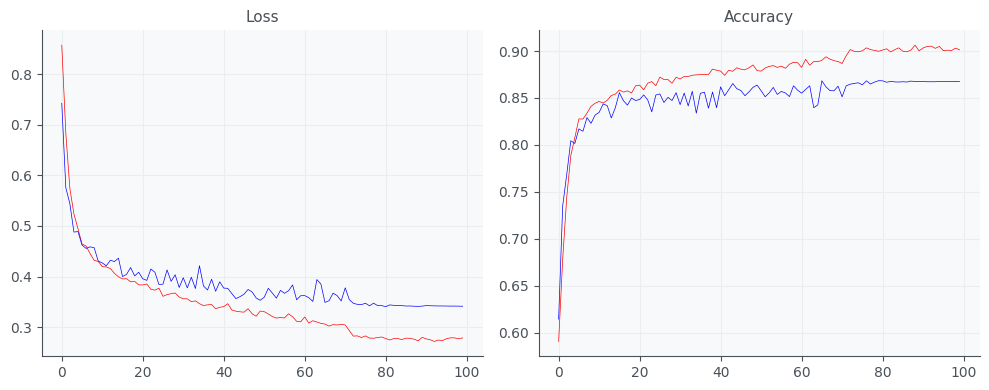

In [ ]:
# save prediction score
y_score = model.predict(x_test)
output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
output.to_csv(os.path.join(OUT_DIR, "LeNet.csv"), index=False)
plot(history.history)


# Test with saved/trained model

In [ ]:
import pickle

import numpy as np
import os
from keras.models import load_model
from scipy.interpolate import splev, splrep
from sklearn.metrics import confusion_matrix

base_dir = DATA_DIR

ir = 3
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))


def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "apnea-ecg.pkl"), 'rb') as f:
        apnea_ecg = pickle.load(f)

    x_train = []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_train[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_train.append([rri_interp_signal, ampl_interp_signal])
    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1))
    y_train = np.array(y_train, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_test[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_test.append([rri_interp_signal, ampl_interp_signal])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return (x_train, y_train, groups_train), (x_test, y_test, groups_test)

In [ ]:
(x_train, y_train, groups_train), (x_test, y_test, groups_test) = load_data()

model = load_model(os.path.join(MODEL_DIR, "model-new.final.h5"))
model.summary()

print("training:")
y_true, y_pred = y_train, np.argmax(model.predict(x_train, batch_size=1024, verbose=1), axis=-1)

C = confusion_matrix(y_true, y_pred, labels=(1, 0))
TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
print("acc: {}, sn: {}, sp: {}".format(acc, sn, sp))

print("testing:")
y_true, y_pred = y_test, np.argmax(model.predict(x_test, batch_size=1024, verbose=1), axis=-1)

C = confusion_matrix(y_true, y_pred, labels=(1, 0))
TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
print("acc: {}, sn: {}, sp: {}".format(acc, sn, sp))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 900, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 448, 32)           352       
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 73, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 24, 64)            0     